## Oncase Exploratory Data Analysis

Análise dos dados extraídos a partir do crawler nos blogs **Tecmundo** e **Tecnoblog**. 

Os dados foram armazendos em uma base local com MongoDB:
<br>
**database**: news
<br>
**collection**: tc_news

Cada registro é composto por 8 colunas, sendo elas:
* **_id**: Id gerado pelo MongoDB
* **link**: Url do artigo
* **author**: Nome do autor do artigo
* **blog**: Nome do blog ao qual o artigo pertence
* **date**: Data de publicação
* **tag**: Lista de tags utilizadas 
* **text**: Corpo do texto do artigo
* **title**: Titulo do artigo

In [1]:
import pymongo
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import iqr
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# get mongodb collection
client = pymongo.MongoClient('localhost', 27017)
articles = client.news.tc_news

In [3]:
articles.find_one()

{'_id': ObjectId('5daf7ee2ca5a68383625b6d8'),
 'link': 'https://tecnoblog.net/311786/netflix-revela-contabiliza-audiencia-filmes-series/',
 'author': 'Victor Hugo Silva',
 'blog': 'Tecnoblog',
 'date': '22/10/2019',
 'tag': 'Netflix',
 'text': 'A Netflix costuma divulgar dados de audiência quando atinge marcas expressivas, como o que aconteceu com o filme Mistério no Mediterrâneo, estrelado por Adam Sandler e Jennifer Aniston, e com a terceira temporada de Stranger Things. A empresa, porém, decidiu revelar como contabiliza sua audiência.A explicação foi feita em uma carta enviada ao Parlamento britânico, que analisa o impacto de serviços sob demanda na TV pública. Segundo a Netflix, os espectadores de suas produções são classificados em três grupos: iniciantes (starters), finalizadores (completers) e observadores (watchers).Os iniciantes são os usuários que assistem a até dois minutos de um filme ou um episódio de série. Os finalizadores, por sua vez, são os que assistem a, no mínimo, 

In [4]:
# entradas para criação do dataFrame
cursor = articles.find()
entries = list(cursor)

In [5]:
df = pd.DataFrame(entries)
df.head()

,_id,author,blog,date,link,tag,text,title
0,5daf7ee2ca5a68383625b6d8,Victor Hugo Silva,Tecnoblog,22/10/2019,https://tecnoblog.net/311786/netflix-revela-co...,Netflix,A Netflix costuma divulgar dados de audiência ...,Netflix revela como contabiliza audiência de f...
1,5daf7ee3ca5a68383625b6da,Felipe Ventura,Tecnoblog,22/10/2019,https://tecnoblog.net/311708/samsung-galaxy-no...,"Android,Android 10,Android Q,One UI,Samsung",A Samsung deve distribuir uma versão beta do A...,Samsung Galaxy Note 10 terá Android 10 beta co...
2,5daf7ee3ca5a68383625b6dc,Paulo Higa,Tecnoblog,22/10/2019,https://tecnoblog.net/311658/asus-lanca-zenfon...,"Asus,Asus Zenfone 6",A Asus lançou na segunda-feira (21) o Zenfone ...,Asus lança Zenfone 6 no Brasil com câmera gira...
3,5daf7ee3ca5a68383625b6de,Victor Hugo Silva,Tecnoblog,22/10/2019,https://tecnoblog.net/311701/governo-podera-co...,"99,Cabify,MEI,Uber",O governo quer estimular motoristas de aplicat...,Governo poderá cobrar imposto de quem trabalha...
4,5daf7ee3ca5a68383625b6e0,Felipe Ventura,Tecnoblog,22/10/2019,https://tecnoblog.net/311762/aliexpress-cogita...,"Alibaba,AliExpress",A varejista online AliExpress estuda abrir um ...,AliExpress cogita abrir armazém no Brasil para...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 8 columns):
_id       2400 non-null object
author    2376 non-null object
blog      2400 non-null object
date      2118 non-null object
link      2400 non-null object
tag       2395 non-null object
text      2400 non-null object
title     2400 non-null object
dtypes: object(8)
memory usage: 150.1+ KB


A base de dados possui um total de **2400** artigos, alguns deles com dados faltantes como o nome do autor, a data de publicação e tag.

In [7]:
print('Artigos sem o nome do autor: ', df['author'].isna().sum())
print('Artigos sem a data de publicação: ', df['date'].isna().sum())
print('Artigos sem tag: ', df['tag'].isna().sum())

Artigos sem o nome do autor:  24
Artigos sem a data de publicação:  282
Artigos sem tag:  5


In [8]:
# removendo a coluna _id, pois não será utilizada na análise
df.drop('_id', axis=1, inplace=True)
df.columns

Index(['author', 'blog', 'date', 'link', 'tag', 'text', 'title'], dtype='object')

#### author

In [9]:
print('Número de autores diferentes: ', df['author'].nunique())

Número de autores diferentes:  71


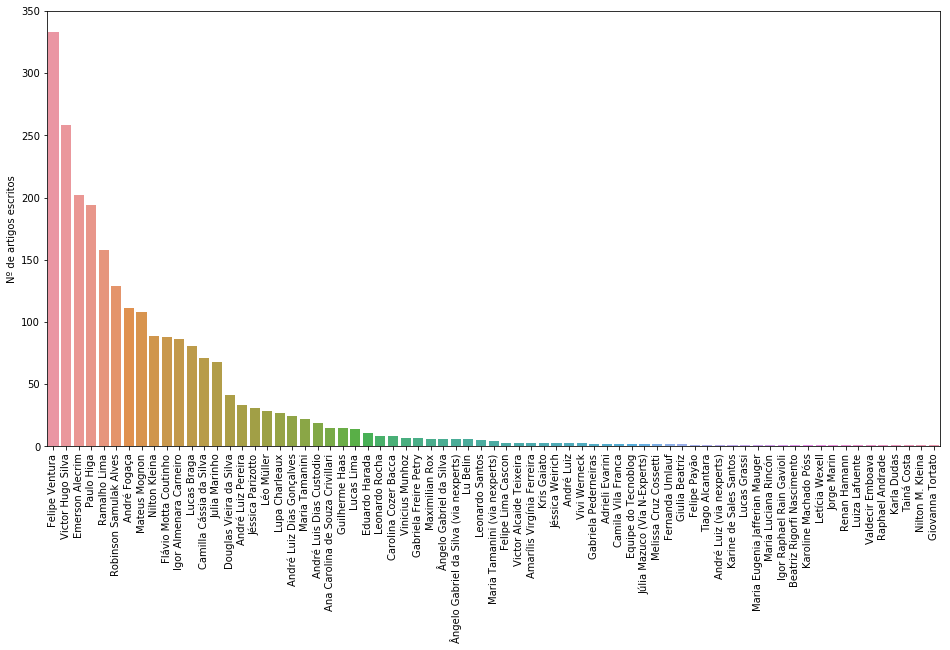

In [10]:
# número de artigos por autor
plt.figure(figsize=(16, 8))
authors = df['author'].value_counts()
sns.barplot(x=authors.index, y=authors)
plt.ylabel('Nº de artigos escritos')
plt.xticks(rotation=90)
plt.show()

In [11]:
# descrevendo pontos estatísticos
authors.describe()

count     71.000000
mean      33.464789
std       64.277930
min        1.000000
25%        1.000000
50%        4.000000
75%       27.500000
max      333.000000
Name: author, dtype: float64

De acordo com os valores estatísticos, temos uma média de 33 artigos por autor, até 25% dos autores escreveu apenas 1 artigos, até 50% escreveu 4 artigos e até 75% escreveu 27 artigos. Além disso, percebemos que tem um autor que escreveu 333 artigos, um número bem significativo em relação aos outros.

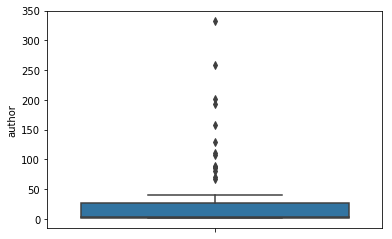

In [13]:
# Verificando outliers
sns.boxplot(y=authors)
plt.show()

In [14]:
# considerando outliers os valores 
# que estão além da faixa -1.5 x IQR to 1.5 x IQR
# sendo IQR (distância interquartil)
outliers = [ol for ol in authors.values if (ol > 1.5*iqr(authors)) or (ol < -1.5*iqr(authors))]
outliers

[333, 258, 202, 194, 158, 129, 111, 108, 89, 88, 86, 81, 71, 68, 41]

In [15]:
print('Temos um total de {} outliers.'.format(len(outliers)))

Temos um total de 15 outliers.


In [16]:
# agrupando autores por blog
author_per_blog = df.groupby(['blog'])['author'].nunique()
author_per_blog

blog
Tecmundo     61
Tecnoblog    10
Name: author, dtype: int64

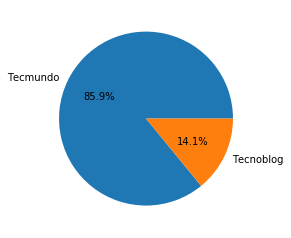

In [17]:
plt.pie(author_per_blog.values, labels=author_per_blog.index, autopct='%1.1f%%')
plt.show()

Pelo gráfico percebemos que o **Tecmundo** possui mais autores do que o Tecnoblog, sendo **85.9% do total de autores** (71 no total) da base de dados.

#### blog

In [18]:
# número de postagens em cada blog
df['blog'].value_counts()

Tecnoblog    1200
Tecmundo     1200
Name: blog, dtype: int64

Temos 1200 artigos do Tecmundo e 1200 artigos do Tecnoblog

#### tag

In [61]:
# transformando os valores NaN para "" 
df.loc[df.tag.isna(), 'tag'] = ""

In [105]:
# criando uma lista com todas as tags possiveis para saber a quantidade de cada
df['tag'] = df['tag'].apply(lambda s: s.lower())
tagList = []
for t in list(df['tag'].values):
    tagList += [i.strip() for i in t.split(',')]

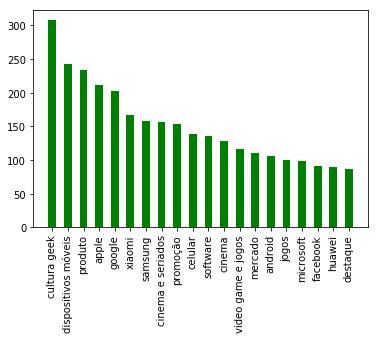

In [135]:
# Plotando gráfico com as 20 tags mais utilizadas
counter = collections.Counter(tagList)
common = dict(counter.most_common(n=20))

plt.bar(common.keys(), common.values(), width=0.5, color='g')
plt.xticks(rotation=90)
plt.show()

In [164]:
# agrupando para saber as tags utilizadas pelo autor que mais escreveu
author_tag = df.groupby(['author', 'tag']).size().to_frame('article with tag by author').reset_index()

In [180]:
# como visto anteriormente, o autor que mais escreveu foi Felipe Ventura
q = 'author == "Felipe Ventura"'
fv_tags = author_tag.query(q)['tag']

fvTagList = []
for t in list(fv_tags.values):
    fvTagList += [i.strip() for i in t.split(',')]

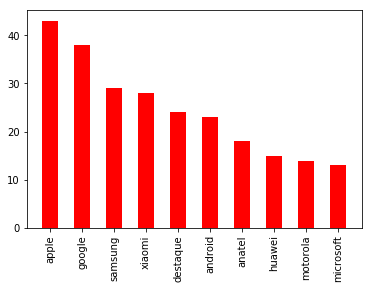

In [185]:
# Plotando gráfico com as 5 tags mais utilizadas pelo Felipe Ventura
counter = collections.Counter(fvTagList)
common = dict(counter.most_common(n=10))

plt.bar(common.keys(), common.values(), width=0.5, color='r')
plt.xticks(rotation=90)
plt.show()

O autor **Felipe Ventura** escreve mais frequentemente sobre fabricantes de celular como apple, samsung, xiaomi e motorola.